# Classification


Original GPflow by *Alexander G. de G. Matthews and James Hensman 2016*

*Adapted to PyTorch by Thomas Viehmann*

This script is similar to

Hensman, Matthews, Ghahramani, AISTATS 2015, Scalable Variational Gaussian Process Classification, Figure 1 Row 1.

It serves to demonstrate sparse variational GP classification on a simple, easily visualized dataset.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import pandas

import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

pyplot.style.use('ggplot')
import IPython

import torch
from torch.autograd import Variable

import candlegp

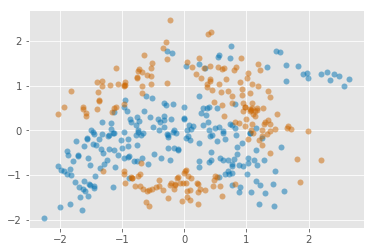

In [2]:
Xtrain = torch.from_numpy(numpy.loadtxt('data/banana_X_train', delimiter=',')).double()
Ytrain = torch.from_numpy(numpy.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)).double()
pyplot.plot(Xtrain[:,0][Ytrain[:, 0]==1].numpy(), Xtrain[:,1][Ytrain[:, 0]==1].numpy(),'o', color='#0172B2', mew=0, alpha=0.5)
pyplot.plot(Xtrain[:,0][Ytrain[:, 0]==0].numpy(), Xtrain[:,1][Ytrain[:, 0]==0].numpy(),'o', color='#CC6600', mew=0, alpha=0.5)

In [3]:
def gridParams():
    mins = [-3.25,-2.85 ] 
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = numpy.linspace( mins[0], maxs[0], nGrid )
    yspaced = numpy.linspace( mins[1], maxs[1], nGrid )
    xx, yy = numpy.meshgrid( xspaced, yspaced )
    Xplot = numpy.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot
     
def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Variable(torch.from_numpy(Xplot)))[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1].numpy(), Xtrain[:,1][Ytrain[:,0]==1].numpy(), 'o', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0].numpy(), Xtrain[:,1][Ytrain[:,0]==0].numpy(), 'o', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'Z'):
        ax.plot(m.Z.get().data.numpy()[:,0], m.Z.get().data.numpy(), 'ko', mew=0, ms=4)
        ax.set_title('{} inducing'.format(m.Z.size(0)))
    ax.contour(xx, yy, p.data.numpy().reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)

def optimize(m, lr=5e-3, it=100, showevery=20):
    opt = torch.optim.LBFGS([p for p in m.parameters() if p.requires_grad], lr=lr, max_iter=40)
    def eval_model():
        obj = m()
        opt.zero_grad()
        obj.backward()
        return obj

    for i in range(it):
        obj = m()
        opt.zero_grad()
        obj.backward()
        opt.step(eval_model)
        if i%showevery==0:
            print(i,':',obj.item())
    return -obj.item()


0 : 397.63094743398324
20 : 269.5311110242517
40 : 269.41731765167475
60 : 269.4172841086185
80 : 269.41728409156116
0 : 269.4172840776013
20 : 222.00428182420183
40 : 219.75637872613763
60 : 219.724743762843
80 : 219.72473678646955
0 : 397.63094743398324
20 : 152.83409909156867
40 : 152.75103158896115
60 : 152.7510164203557
80 : 152.75101640386995
0 : 152.75101639039923
20 : 139.72311760024314
40 : 139.71901253492248
60 : 139.71901203788732
80 : 139.71901202254378
0 : 397.63094743398324
20 : 121.32681020294058
40 : 121.17428328537679
60 : 121.17425061356379
80 : 121.17425059682922
0 : 121.17425058330002
20 : 112.97810104306791
40 : 112.88636497537317
60 : 112.88630816065292
80 : 112.88630814340706
0 : 397.63094743398324
20 : 110.30027356245766
40 : 109.46626203701925
60 : 109.46555739123202
80 : 109.46555736137765
0 : 109.46555734642749
20 : 107.01591022626181
40 : 106.8965694593652
60 : 106.86985649237576
80 : 106.86286310182521
0 : 397.63094743398324
20 : 107.64176426613862
40 : 107

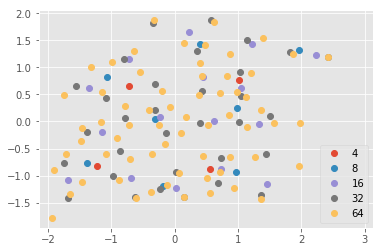

In [5]:
# Setup the experiment and plotting.
Ms = [4, 8, 16, 32, 64]


# Run sparse classification with increasing number of inducing points
models = []
for index, num_inducing in enumerate(Ms):
    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans
    Z = torch.from_numpy(kmeans(Xtrain.numpy(), num_inducing)[0])
    pyplot.plot(Z[:,0].numpy(),Z[:,1].numpy(),'o', label=num_inducing)
    
    m = candlegp.models.SVGP(Variable(Xtrain), Variable(Ytrain),
                         kern=candlegp.kernels.RBF(2).double(),
                         likelihood=candlegp.likelihoods.Bernoulli(), Z=Variable(Z))
    #Initially fix the hyperparameters.
    m.Z.requires_grad = False
    optimize(m)
    m.Z.requires_grad = True
    optimize(m)
    models.append(m)
    if 0:
        m = gpflow.models.SVGP(Xtrain, Ytrain,
                             kern=gpflow.kernels.RBF(2),
                             likelihood=gpflow.likelihoods.Bernoulli(), Z=Z)
        #Initially fix the hyperparameters.
        m.Z.set_trainable(False)
        m.compile()
        gpflow.train.ScipyOptimizer(options=dict(maxiter=20)).minimize(m)

        #Unfix the hyperparameters.
        m.Z.set_trainable(True)
        gpflow.train.ScipyOptimizer(options=dict(maxiter=200)).minimize(m)
        models.append(m)

xl = pyplot.xlim() ; pyplot.xlim(xl[0], xl[1]+0.5)
pyplot.legend(loc='lower right')

In [6]:
#Run variational approximation without sparsity..
#..be aware that this is much slower.
m = candlegp.models.VGP(Variable(Xtrain), Variable(Ytrain),
                        kern=candlegp.kernels.RBF(2).double(),
                        likelihood=candlegp.likelihoods.Bernoulli())
optimize(m, showevery=1, it=20)
models.append(m)

0 : 397.63105987663505
1 : 296.0727377779622
2 : 242.6138497502597
3 : 207.36390027967641
4 : 170.6562321320797
5 : 145.87947989428298
6 : 133.99369250703674
7 : 125.43080367400458
8 : 119.69216147413525
9 : 115.88749358548341
10 : 113.30493445316634
11 : 111.55926848878025
12 : 110.291627324052
13 : 109.39907153531684
14 : 108.7540216414089
15 : 108.26688912609058
16 : 107.90332376412739
17 : 107.619646610824
18 : 107.39574610630828
19 : 107.21936288612613


[]

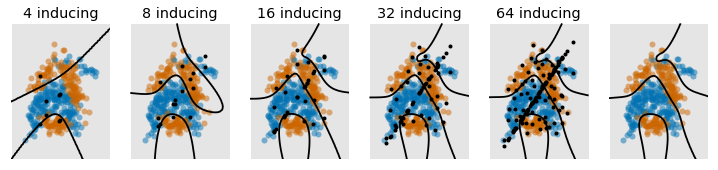

In [7]:
# make plots.
fig, axes = pyplot.subplots(1, len(models), figsize=(12.5, 2.5), sharex=True, sharey=True)
for i, m in enumerate(models):
    plot(m, axes[i])
axes[i].set_yticks([])
axes[i].set_xticks([])

Note that the original implementation and the article do not show the diagonal line of inducing points visible for 32 and 62 inducing. This probably is a bug in the candlegp library.